# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


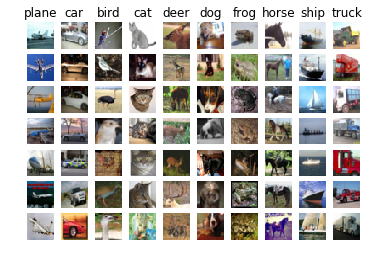

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


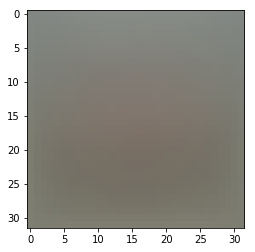

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.425633


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -17.936022 analytic: -17.936022, relative error: 6.744522e-13
numerical: 27.779024 analytic: 27.779024, relative error: 1.792073e-11
numerical: -0.755967 analytic: -0.755967, relative error: 3.491923e-10
numerical: -10.148657 analytic: -10.148657, relative error: 1.340110e-11
numerical: 6.974946 analytic: 6.974946, relative error: 1.414322e-11
numerical: -12.849208 analytic: -12.849208, relative error: 9.822615e-12
numerical: 9.620528 analytic: 9.620528, relative error: 7.503126e-12
numerical: 38.346660 analytic: 38.346660, relative error: 5.609237e-12
numerical: -15.041292 analytic: -15.041292, relative error: 8.219609e-12
numerical: 5.781277 analytic: 5.781277, relative error: 7.405441e-11
numerical: 9.616319 analytic: 9.616319, relative error: 9.324918e-12
numerical: -24.140322 analytic: -24.140322, relative error: 5.229660e-12
numerical: 1.682400 analytic: 1.682400, relative error: 2.541527e-10
numerical: -15.826894 analytic: -15.826894, relative error: 5.068437e-12
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.425633e+00 computed in 0.191393s
Vectorized loss: 9.425633e+00 computed in 0.013268s
difference: -0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.226554s
Vectorized loss and gradient: computed in 0.003861s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [26]:
X_my_test = np.arange(9).reshape(3,3)
print(X_my_test)
my_batch_index = np.random.choice(a=3, size=2, replace=True)
print(my_batch_index)
X_my_batch = X_my_test[my_batch_index, :]
print(X_my_batch)
Y_my_test = np.array([0,1,2])
print(Y_my_test)
Y_my_batch = Y_my_test[my_batch_index]
print(Y_my_batch)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[2 2]
[[6 7 8]
 [6 7 8]]
[0 1 2]
[2 2]


In [35]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 804.652015
iteration 100 / 1500: loss 292.567416
iteration 200 / 1500: loss 109.941605
iteration 300 / 1500: loss 43.353275
iteration 400 / 1500: loss 18.706719
iteration 500 / 1500: loss 10.409935
iteration 600 / 1500: loss 7.133056
iteration 700 / 1500: loss 6.571916
iteration 800 / 1500: loss 5.666523
iteration 900 / 1500: loss 5.036122
iteration 1000 / 1500: loss 5.256170
iteration 1100 / 1500: loss 5.603460
iteration 1200 / 1500: loss 4.974142
iteration 1300 / 1500: loss 5.031316
iteration 1400 / 1500: loss 5.101813
That took 6.218596s


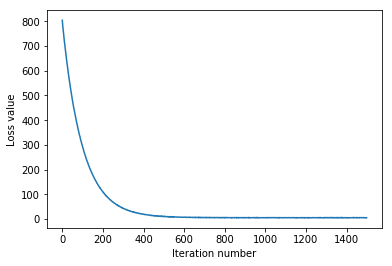

In [36]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [39]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368551
validation accuracy: 0.385000


In [42]:
learning_rates = [1e-5, 5e-5]
regularization_strengths = [2.5e4, 5e4]

print(np.arange(learning_rates[0], learning_rates[1], 1e-6))
print(np.arange(regularization_strengths[0], regularization_strengths[1], 1e3))

[1.0e-05 1.1e-05 1.2e-05 1.3e-05 1.4e-05 1.5e-05 1.6e-05 1.7e-05 1.8e-05
 1.9e-05 2.0e-05 2.1e-05 2.2e-05 2.3e-05 2.4e-05 2.5e-05 2.6e-05 2.7e-05
 2.8e-05 2.9e-05 3.0e-05 3.1e-05 3.2e-05 3.3e-05 3.4e-05 3.5e-05 3.6e-05
 3.7e-05 3.8e-05 3.9e-05 4.0e-05 4.1e-05 4.2e-05 4.3e-05 4.4e-05 4.5e-05
 4.6e-05 4.7e-05 4.8e-05 4.9e-05 5.0e-05]
[25000. 26000. 27000. 28000. 29000. 30000. 31000. 32000. 33000. 34000.
 35000. 36000. 37000. 38000. 39000. 40000. 41000. 42000. 43000. 44000.
 45000. 46000. 47000. 48000. 49000.]


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                     #
################################################################################
# Your code

for rate in learning_rates:
    for regular in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=rate, reg=regular,
                      num_iters=1500)
        y_train_pred = svm.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(rate, regular)]=(accuracy_train, accuracy_val)
        if (best_val < accuracy_val):
            best_val = accuracy_val
            best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 795.316974
iteration 100 / 1500: loss 291.013499
iteration 200 / 1500: loss 108.759709
iteration 300 / 1500: loss 42.797350
iteration 400 / 1500: loss 19.267362
iteration 500 / 1500: loss 10.473552
iteration 600 / 1500: loss 7.710978
iteration 700 / 1500: loss 5.906142
iteration 800 / 1500: loss 5.525270
iteration 900 / 1500: loss 5.563209
iteration 1000 / 1500: loss 5.815182
iteration 1100 / 1500: loss 5.460482
iteration 1200 / 1500: loss 5.410782
iteration 1300 / 1500: loss 5.196704
iteration 1400 / 1500: loss 5.465151
iteration 0 / 1500: loss 943.173040
iteration 100 / 1500: loss 281.079519
iteration 200 / 1500: loss 87.969312
iteration 300 / 1500: loss 29.732364
iteration 400 / 1500: loss 12.754840
iteration 500 / 1500: loss 8.077874
iteration 600 / 1500: loss 5.939396
iteration 700 / 1500: loss 6.009548
iteration 800 / 1500: loss 5.622523
iteration 900 / 1500: loss 5.580230
iteration 1000 / 1500: loss 5.288553
iteration 1100 / 1500: loss 5.032955
iteration

iteration 1100 / 1500: loss 121.455632
iteration 1200 / 1500: loss 72.363693
iteration 1300 / 1500: loss 105.586959
iteration 1400 / 1500: loss 82.023466
iteration 0 / 1500: loss 798.496388
iteration 100 / 1500: loss 142.887651
iteration 200 / 1500: loss 99.153038
iteration 300 / 1500: loss 87.376485
iteration 400 / 1500: loss 99.483387
iteration 500 / 1500: loss 116.868105
iteration 600 / 1500: loss 102.072519
iteration 700 / 1500: loss 142.492678
iteration 800 / 1500: loss 77.675655
iteration 900 / 1500: loss 163.759798
iteration 1000 / 1500: loss 128.237655
iteration 1100 / 1500: loss 105.686667
iteration 1200 / 1500: loss 94.497675
iteration 1300 / 1500: loss 125.432627
iteration 1400 / 1500: loss 111.100786
iteration 0 / 1500: loss 934.083037
iteration 100 / 1500: loss 166.073549
iteration 200 / 1500: loss 133.044610
iteration 300 / 1500: loss 139.578649
iteration 400 / 1500: loss 117.120993
iteration 500 / 1500: loss 104.519189
iteration 600 / 1500: loss 189.793666
iteration 700 

iteration 1200 / 1500: loss 638081672557332.500000
iteration 1300 / 1500: loss 3140624863525559.000000
iteration 1400 / 1500: loss 15457427543060656.000000
iteration 0 / 1500: loss 1407.174922
iteration 100 / 1500: loss 459039902346553319227392.000000
iteration 200 / 1500: loss 46451148905036763378518278124009611054809088.000000
iteration 300 / 1500: loss 4700482949981101333926964864419742383782259766259708960790544384.000000
iteration 400 / 1500: loss 475651097634472126425027702161021726616346182674662784677025397549870628738330263552.000000
iteration 500 / 1500: loss 48132068361568603380795504930947799258727601956705960928317519398439829360888496671932654293425445666816.000000
iteration 600 / 1500: loss 4870578489746376113995980021304900837920355696401916276271214809266922649775002935672040992987182255634258030473526967795712.000000
iteration 700 / 1500: loss 492863399232631450617865947377601015274693692990921463753839391953780567960238946824863194937303953219754387581503064361795116

/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W*W)
/home/g214-j/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W*W)


iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1399.632514
iteration 100 / 1500: loss 71163058998816528158471995852229207849372724756480.000000
iteration 200 / 1500: loss 2515748094661903811074149192548714519437608082457694931873726537251448710532408607337587037700096.000000
iteration 300 / 1500: loss 88936430851015710098158078941672656886973207333973974056011946331845075615628732161553630009104532959980749514538600920831698675495908208017408.000000
iteration 400 / 1500: loss 3144070246659771163922594475340975533821604092076162498036492445567300298230868036364260169052280997658460940188407758642252201898463771301989073062590745400489652111294591903362287960850432.000000
iteration 500 / 1500: loss 11114880169287049316067398943115250692149565985165863146069564550911556051454159713255500929030630531291001277688875883038851694776109007463345488964210595923381636664457451503466078080142

/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in subtract
  mask = (scores - y_correct_class_scores + 1) > 0
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in subtract
  zheye_scores = (scores - y_correct_class_scores + 1) * mask
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: invalid value encountered in multiply
  zheye_scores = (scores - y_correct_class_scores + 1) * mask
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/g214-j/cs231camp/git_cs231_camp_orig/cs231n-camp/assignment/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: invalid valu

iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 788.931133
iteration 100 / 1500: loss 5536.446492
iteration 200 / 1500: loss 5612.889266
iteration 300 / 1500: loss 5919.976365
iteration 400 / 1500: loss 5439.172932
iteration 500 / 1500: loss 5345.843965
iteration 600 / 1500: loss 5366.170743
iteration 700 / 1500: loss 5833.304635
iteration 800 / 1500: loss 5368.373527
iteration 900 / 1500: loss 5376.120899
iteration 1000 / 1500: loss 5230.562230
iteration 1100 / 1500: loss 5880.359106
iteration 1200 / 1500: loss 5276.901085
iteration 1300 / 1500: loss 4942.267103
iteration 1400 / 1500: loss 5991.446156
iteration 0 / 1500: loss 935.254112
iteration 100 / 1500: loss 13058917239359.287109
iteration 200 / 1500: loss 7361501665111229595648.000000
iteration 300 / 1500: loss 4149462173455624496239737831424.000000
iteration 400 / 1500: loss 2338929888512818579056000392630546464768.000000
iteration 500 / 1500: loss 1318386044912888017925256869757839338743024058368.000000
iteration 600 

iteration 800 / 1500: loss 1714402408001291455274645010797446327631475330799318027664127075225506111808009653929203490142750135649526688940620437257105775219314825061170875797656886171964313444133403149065683951961997381168231598647000344668367982907207224599064346624.000000
iteration 900 / 1500: loss 677917593203352069039853053788570105847408111758858099257092087372160280025612363197101984188960337061229737104792422933391467979613382794315098714370794250251699688491293175548790347759810341966520442545841838278447518656325197377908243243678900469996550663695614607360.000000
iteration 1000 / 1500: loss 268065572604048441328783107443805977468346781610838388207060852980479066859750067147248718652226455757469861557753600723475321535984042334925079760572229371307893699746460384327621490566048466459496358651243624159644083899027087107792209229134610221968637217535443533337958018995916196866573478133760.000000
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 15

iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1101.714239
iteration 100 / 1500: loss 8324430198927452173318349832799326031643820988862491171290189597245440.000000
iteration 200 / 1500: loss 49021154662429519701403738150881859640353294170320687866689295123708169753853020468390449237062501800676087669002128755051963678564810752.000000
iteration 300 / 1500: loss 288677248413645876040419589433016365567717808324854828379632810385905302617664390854748006277131062136213538770037535954992460106435435766276179518425418897292096843967373045144438166565469836359499776000.000000
iteration 400 / 1500: loss 16999712537481811015321697020070704551614445164118581541231878632233138009197397003029903429282142049282967907670117953584154587251117833009565046333255276344995699556

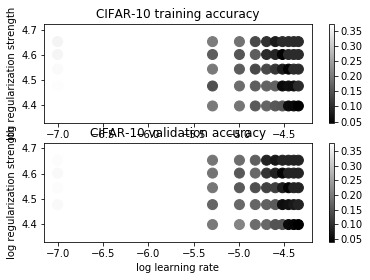

In [48]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [49]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


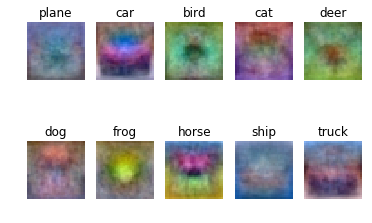

In [50]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*
每一个分类就对应一个线性的SVM分类器，分类器权重的维度等于图像的维度，相当于一个图像模板，该模板中的权重对该类中相应特征就有对最终分类影响的大小之分，所以学习到的模板能反应该类的一般特性，可视化结果就能看到模糊的该类的一些语义特征。